In [27]:
import math
import numpy as np
import pandas as pd 
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [2]:
'''#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster'''

In [3]:
df=pd.read_csv("../dataset-progetto/train.csv", skipinitialspace=True)


#  HIERARCHICAL CLUSTERING

----------------------------------------------------------------------
## visualizzazione e selezione degli attributi da trasformare / eliminare

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   15000 non-null  object 
 1   duration_ms            15000 non-null  int64  
 2   explicit               15000 non-null  bool   
 3   popularity             15000 non-null  int64  
 4   artists                15000 non-null  object 
 5   album_name             15000 non-null  object 
 6   danceability           15000 non-null  float64
 7   energy                 15000 non-null  float64
 8   key                    15000 non-null  int64  
 9   loudness               15000 non-null  float64
 10  mode                   10550 non-null  float64
 11  speechiness            15000 non-null  float64
 12  acousticness           15000 non-null  float64
 13  instrumentalness       15000 non-null  float64
 14  liveness               15000 non-null  float64
 15  va

In [5]:
df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

C:\Users\lollo\AppData\Local\Temp\ipykernel_2012\22157288.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing
duration_ms,1.000000,-0.048723,-0.076202,-0.080932,0.102996,0.016712,0.039403,-0.023310,-0.074774,-0.184902,0.079685,-0.021184,-0.141938,0.048765,0.999918,0.009033,0.839313,0.838041,-0.005830,-0.010400
explicit,-0.048723,1.000000,-0.013096,0.056992,0.124405,-0.000991,0.131777,-0.042846,0.294287,-0.113975,-0.125101,0.006995,0.008631,0.016972,-0.048699,0.051260,-0.039830,-0.039435,0.029119,-0.005878
popularity,-0.076202,-0.013096,1.000000,0.051046,-0.056547,-0.008992,0.046703,0.073043,-0.096382,0.078424,-0.266843,0.027105,0.077652,-0.024162,-0.076228,-0.003160,-0.084774,-0.089134,-0.003665,0.008733
danceability,-0.080932,0.056992,0.051046,1.000000,0.193940,0.035311,0.385244,-0.072422,0.111454,-0.199082,-0.202316,-0.174193,0.559578,0.092267,-0.080891,0.292167,-0.033604,-0.069332,0.011602,-0.026273
energy,0.102996,0.124405,-0.056547,0.193940,1.000000,0.057815,0.720907,-0.079969,0.143454,-0.699454,-0.203111,0.191024,0.284069,0.331538,0.102985,0.204646,0.243586,0.208615,0.040022,-0.037847
key,0.016712,-0.000991,-0.008992,0.035311,0.057815,1.000000,0.047718,-0.157515,0.018157,-0.049867,-0.001532,-0.007420,0.028221,0.022414,0.016786,0.028388,0.027133,0.022042,0.019790,-0.490366
loudness,0.039403,0.131777,0.046703,0.385244,0.720907,0.047718,1.000000,-0.033544,0.109793,-0.552519,-0.447106,0.047502,0.377743,0.308203,0.039415,0.250568,0.165565,0.131064,0.049174,-0.020563
mode,-0.023310,-0.042846,0.073043,-0.072422,-0.079969,-0.157515,-0.033544,1.000000,-0.064289,0.085246,-0.080035,0.015738,-0.006907,-0.013001,-0.023409,-0.019378,-0.030685,-0.027687,0.003698,0.261129
speechiness,-0.074774,0.294287,-0.096382,0.111454,0.143454,0.018157,0.109793,-0.064289,1.000000,-0.087997,-0.115803,0.050034,0.056068,0.062161,-0.074722,0.080739,-0.043217,-0.040820,0.026399,-0.022909
acousticness,-0.184902,-0.113975,0.078424,-0.199082,-0.699454,-0.049867,-0.552519,0.085246,-0.087997,1.000000,0.094256,-0.075924,-0.131961,-0.244244,-0.184846,-0.139706,-0.283324,-0.248164,-0.021155,0.022684


### time signature lo riempio con la moda

In [6]:
# Calcola la moda della colonna "time_signature"
mode_time_signature = df['time_signature'].mode().iloc[0]

# Rimpiazza i valori mancanti con la moda
df['time_signature'].fillna(mode_time_signature, inplace=True)

print('null presenti: ',df['time_signature'].isnull().sum())

null presenti:  0


### popularity confidence lo elimino x i troppi null

In [7]:
df = df.drop('popularity_confidence', axis=1)
df.head() #oki non c'è più

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.53600,0.281,0.6350,142.221,241760,4.0,567.0,141.0,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.93400,0.360,0.0336,75.596,444000,4.0,617.0,155.0,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.80000,0.262,0.4890,116.628,333507,4.0,652.0,162.0,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.00127,0.117,0.3850,140.880,269800,4.0,619.0,155.0,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.09690,0.299,0.6370,143.956,307652,4.0,733.0,183.0,4.067086,happy


### tolgo anche mode perchè non mi va 

In [8]:
df = df.drop('mode', axis=1)
df.head() #oki non c'è più

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.53600,0.281,0.6350,142.221,241760,4.0,567.0,141.0,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.93400,0.360,0.0336,75.596,444000,4.0,617.0,155.0,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.80000,0.262,0.4890,116.628,333507,4.0,652.0,162.0,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.00127,0.117,0.3850,140.880,269800,4.0,619.0,155.0,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.09690,0.299,0.6370,143.956,307652,4.0,733.0,183.0,4.067086,happy


### binarizzo explicit perchè è un booleano

In [9]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)

### tolgo features duration perchè troppo simile alla duration

In [10]:
df = df.drop('features_duration_ms' , axis = 1)

### correlazioni

In [11]:
df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

C:\Users\lollo\AppData\Local\Temp\ipykernel_2012\22157288.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


,duration_ms,explicit,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,n_bars,processing
duration_ms,1.000000,-0.048723,-0.076202,-0.080932,0.102996,0.016712,0.039403,-0.074774,-0.184902,0.079685,-0.021184,-0.141938,0.048765,0.008208,0.839313,0.838041,-0.010400
explicit,-0.048723,1.000000,-0.013096,0.056992,0.124405,-0.000991,0.131777,0.294287,-0.113975,-0.125101,0.006995,0.008631,0.016972,0.047941,-0.039830,-0.039435,-0.005878
popularity,-0.076202,-0.013096,1.000000,0.051046,-0.056547,-0.008992,0.046703,-0.096382,0.078424,-0.266843,0.027105,0.077652,-0.024162,-0.002659,-0.084774,-0.089134,0.008733
danceability,-0.080932,0.056992,0.051046,1.000000,0.193940,0.035311,0.385244,0.111454,-0.199082,-0.202316,-0.174193,0.559578,0.092267,0.274946,-0.033604,-0.069332,-0.026273
energy,0.102996,0.124405,-0.056547,0.193940,1.000000,0.057815,0.720907,0.143454,-0.699454,-0.203111,0.191024,0.284069,0.331538,0.191553,0.243586,0.208615,-0.037847
key,0.016712,-0.000991,-0.008992,0.035311,0.057815,1.000000,0.047718,0.018157,-0.049867,-0.001532,-0.007420,0.028221,0.022414,0.026923,0.027133,0.022042,-0.490366
loudness,0.039403,0.131777,0.046703,0.385244,0.720907,0.047718,1.000000,0.109793,-0.552519,-0.447106,0.047502,0.377743,0.308203,0.235546,0.165565,0.131064,-0.020563
speechiness,-0.074774,0.294287,-0.096382,0.111454,0.143454,0.018157,0.109793,1.000000,-0.087997,-0.115803,0.050034,0.056068,0.062161,0.075101,-0.043217,-0.040820,-0.022909
acousticness,-0.184902,-0.113975,0.078424,-0.199082,-0.699454,-0.049867,-0.552519,-0.087997,1.000000,0.094256,-0.075924,-0.131961,-0.244244,-0.131329,-0.283324,-0.248164,0.022684
instrumentalness,0.079685,-0.125101,-0.266843,-0.202316,-0.203111,-0.001532,-0.447106,-0.115803,0.094256,1.000000,-0.088589,-0.348955,-0.117466,-0.115587,0.034830,0.044498,-0.012960


----------------------------------------------
##  analizzo attributi categorici e i numerali

In [12]:
df.dtypes[df.dtypes.map(lambda x: x == 'int64')]

duration_ms    int64
explicit       int64
popularity     int64
key            int64
dtype: object

In [13]:
df.dtypes[df.dtypes.map(lambda x: x == 'float64')]

danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
n_beats             float64
n_bars              float64
processing          float64
dtype: object

In [14]:
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

name          object
artists       object
album_name    object
genre         object
dtype: object

In [15]:
ueue = len(df.dtypes[df.dtypes.map(lambda x: x == 'float64')]) +len(df.dtypes[df.dtypes.map(lambda x: x == 'object')]) + len(df.dtypes[df.dtypes.map(lambda x: x == 'int64')]) 
print('tot attributi =', ueue)

tot attributi = 21


### tolgo i categorical

In [16]:
df_train = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
df_train.head()

,duration_ms,explicit,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,n_bars,processing
0,241760,0,46,0.690,0.513,5,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,567.0,141.0,1.279305
1,444000,0,0,0.069,0.196,1,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,617.0,155.0,2.367412
2,333506,0,3,0.363,0.854,2,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,652.0,162.0,3.700483
3,269800,0,23,0.523,0.585,5,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,619.0,155.0,1.279305
4,307651,0,25,0.643,0.687,7,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,733.0,183.0,4.067086


In [17]:
df_train = df_train.drop(['explicit','popularity','key','energy','loudness','danceability','speechiness','acousticness','time_signature','instrumentalness','liveness','valence','processing','n_bars'], axis=1)
df_train.dtypes

duration_ms      int64
tempo          float64
n_beats        float64
dtype: object

-----------------------------------
## normalizzazione dati

In [18]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train)

-------------------------------------------------------------------
## clustering

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [20]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(train_data)

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


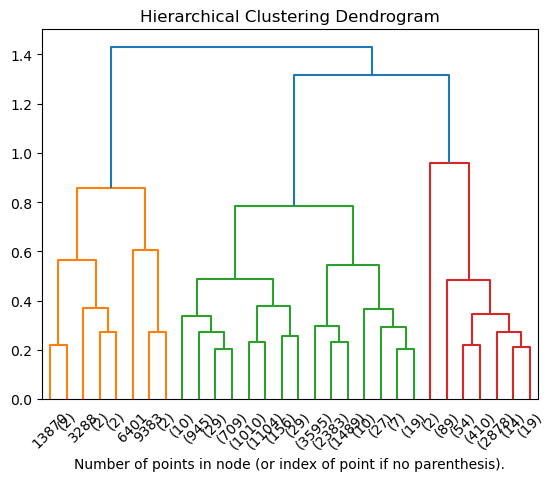

In [21]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [22]:
hier = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hier.fit(train_data)

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=3)

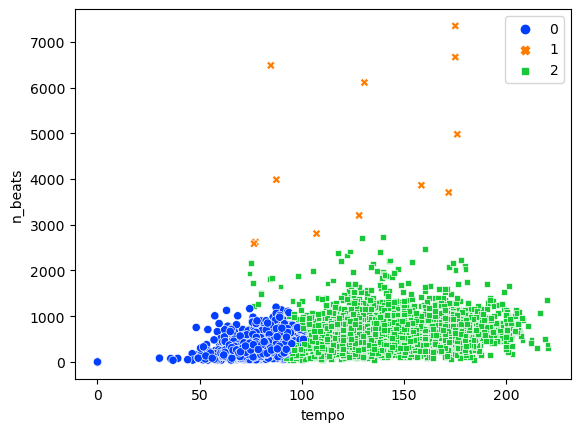

In [25]:
sns.scatterplot(data=df_train, x="tempo", y="n_beats", hue=hier.labels_, 
                style=hier.labels_, palette="bright")
plt.show()

### connectivity constraint (copiato prof non capisco cazzo faccia)

In [28]:
# hierarchical clustering
connectivity = kneighbors_graph(train_data, n_neighbors=100, include_self=False)

In [29]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None, affinity='euclidean', 
                                linkage='ward', connectivity=connectivity)
model = model.fit(train_data)

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


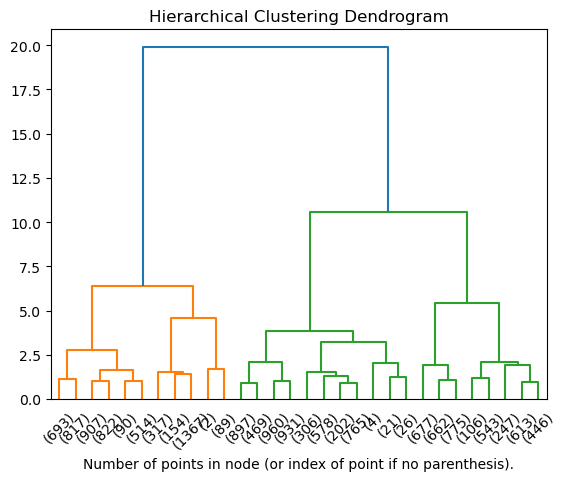

In [30]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [31]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean',
                                   connectivity=connectivity)
ward.fit(train_data)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, ward.labels_))

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


labels {0: 5772, 1: 4069, 2: 5159}


MemoryError: Unable to allocate 1.00 GiB for an array with shape (8947, 15000) and data type float64

In [ ]:
print('complete linkage')
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='l1',
                                              connectivity=connectivity)
complete_linkage.fit(train_data)
hist, bins = np.histogram(complete_linkage.labels_, 
                          bins=range(0, len(set(complete_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, complete_linkage.labels_))